In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepMacroFin import PDEModel
from deepMacroFin import ActivationType, Comparator, EndogVar, EndogVarConditions, EndogEquation

## Second order linear ODE
$$y''-10y'+9y=5t, y(0)=-1, y'(0)=2$$

Solution: $y=\frac{50}{81} + \frac{5}{9}t + \frac{31}{81}e^{9t} - 2e^t$

In [2]:
ode = PDEModel("second_order_linear", config={"num_epochs": 10000})
ode.set_state(["t"], {"t": [0., 0.25]})
ode.add_endog("y", config={
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "hidden_units": [50, 50, 50],
    "activation_type": ActivationType.Tanh,
    "positive": False,
    "derivative_order": 2,
})
ode.add_endog_equation("y_tt-10*y_t+9*y=5*t", label="base_ode", weight=0.01)
ode.add_endog_condition("y", 
                            "y(SV)", {"SV": torch.zeros((1, 1))},
                            Comparator.EQ,
                            "-1", {},
                            label="ic1")
ode.add_endog_condition("y", 
                            "y_t(SV)", {"SV": torch.zeros((1, 1))},
                            Comparator.EQ,
                            "2", {},
                            label="ic2")
print(ode)
if not os.path.exists("./models/second_order_ode3.pt"):
    ode.train_model("./models", "second_order_ode3.pt", True)
    ode.eval_model(True)
else:
    ode.load_model(torch.load("./models/second_order_ode3.pt"))
    ode.eval_model()

======================Summary of Model second_order_linear======================
Config: {
 "num_epochs": 10000
}
Latex Variable Mapping: {}

================================State Variables=================================
t: [0.0, 0.25]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: y
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (activation_2): Tanh()
    (final_layer): Linear(in_features=50, out_features=1, bias=True)
  )
)
Num parameters: 5251
------------------------------------------------------------------------------

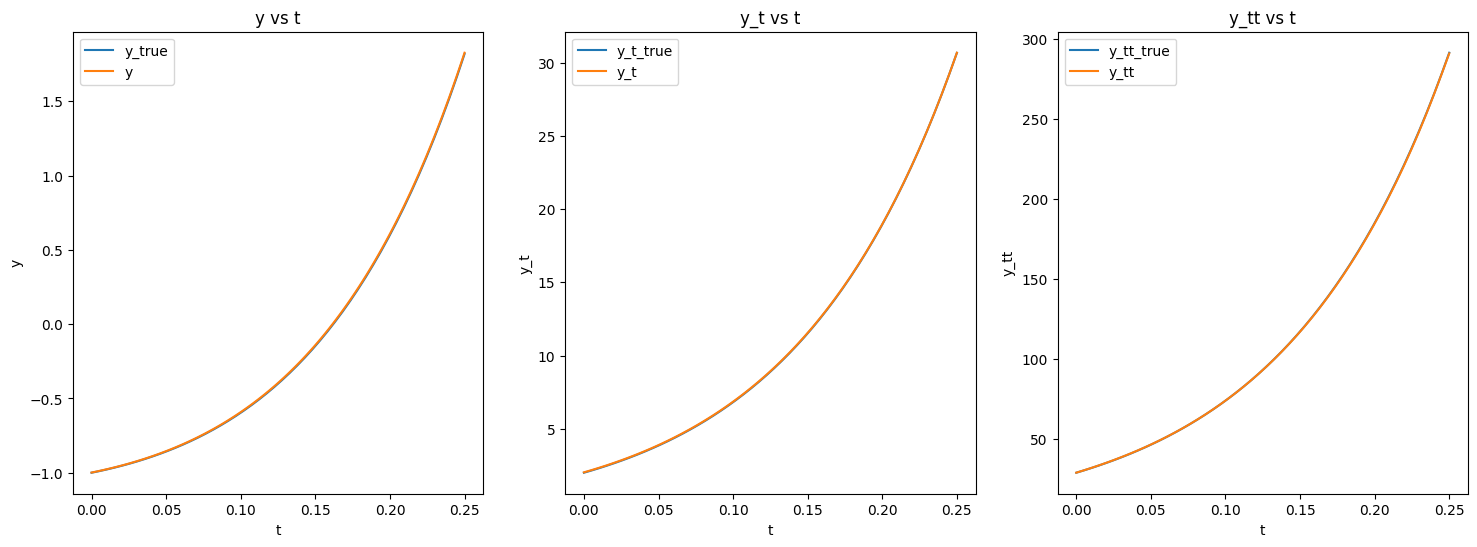

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
x = np.linspace(0, 0.25)
ax[0].plot(x, 50/81+5/9*x+31/81*np.exp(9*x)-2*np.exp(x), label="y_true")
ax[1].plot(x, 5/9+31/9*np.exp(9*x)-2*np.exp(x), label="y_t_true")
ax[2].plot(x, 31*np.exp(9*x)-2*np.exp(x), label="y_tt_true")
ode.endog_vars["y"].plot("y", {"t": [0, 0.25]}, ax=ax[0])
ode.endog_vars["y"].plot("y_t", {"t": [0, 0.25]}, ax=ax[1])
ode.endog_vars["y"].plot("y_tt", {"t": [0, 0.25]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

## deepxde result

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.368740 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.79e-02, 1.00e+00, 3.69e+00]    [1.84e-02, 1.00e+00, 3.69e+00]    [9.96e-01]    
1000      [1.10e+00, 8.93e-01, 8.88e-01]    [1.09e+00, 8.93e-01, 8.88e-01]    [9.39e-01]    
2000      [3.58e-04, 4.99e-07, 2.93e-06]    [4.11e-04, 4.99e-07, 2.93e-06]    [1.48e-03]    
3000      [1.09e-04, 2.51e-08, 9.71e-07]    [1.53e-04, 2.51e-08, 9.71e-07]    [4.24e-04]    
4000      [8.39e-05, 1.23e-08, 2.77e-07]    [1.20e-04, 1.23e-08, 2.77e-07]    [3.90e-04]    
5000      [1.72e-02, 1.45e-05, 1.53e-02]    [1.76e-02, 1.45e-05, 1.53e-02]    [2.03e-02]    
6000      [4.90e-05, 1.78e-09, 1.11e-08]    [7.21e-05, 1.78e-09, 1.11e-08]    [3.61e-04]    
7000      [3.61e-05, 3.70e-11, 6.20e-08]    [5.39e-05, 3.70e-11, 6.20e-08]    [3.38e-04]    
8000      [2.78e-05, 5.38e-10, 9.09e-13]    [4.30e-05, 5.38e-10, 9.09e-13]    [2.77e-04]    
9000 

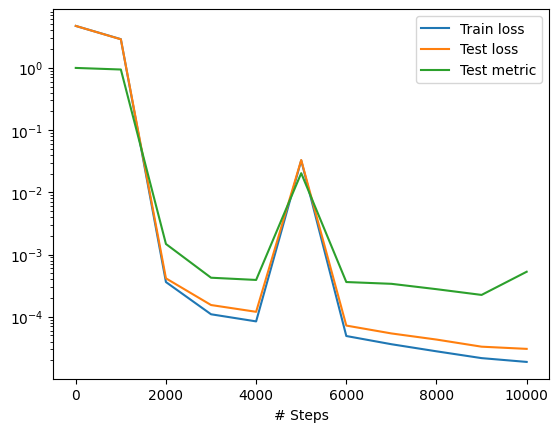

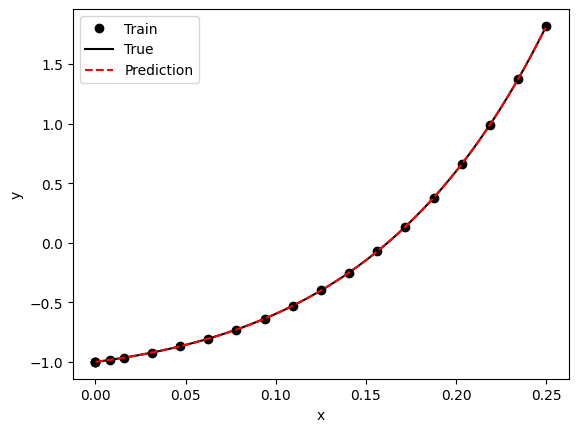

In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np


def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t


def func(t):
    return 50 / 81 + t * 5 / 9 - 2 * np.exp(t) + (31 / 81) * np.exp(9 * t)


geom = dde.geometry.TimeDomain(0, 0.25)


def boundary_l(t, on_initial):
    return on_initial and dde.utils.isclose(t[0], 0)


def bc_func1(inputs, outputs, X):
    return outputs + 1


def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 2


ic1 = dde.icbc.IC(geom, lambda x: -1, lambda _, on_initial: on_initial)
ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

data = dde.data.TimePDE(geom, ode, [ic1, ic2], 16, 2, solution=func, num_test=500)
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[0.01, 1, 1]
)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)